## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [3]:
np.random.seed(0)

## Generate data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


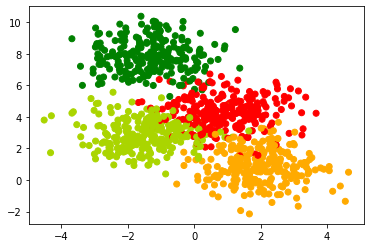

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

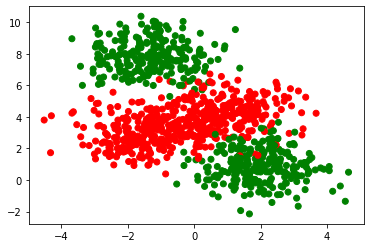

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

## Multi class classification

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels_orig, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [9]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train,1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [10]:
W1 = np.random.randn(2,2)
W2 = np.random.randn(2,4)
print(W1)
print(W2)

[[1.76405235 0.40015721]
 [0.97873798 2.2408932 ]]
[[ 1.86755799 -0.97727788  0.95008842 -0.15135721]
 [-0.10321885  0.4105985   0.14404357  1.45427351]]


# FFN Vectorised

In [11]:
class FFNetwork:
  
    def __init__(self, W1, W2):
        self.params = {}
        self.params["W1"] = W1.copy()
        self.params["W2"] = W2.copy()
        self.params["B1"] = np.zeros((1,2))
        self.params["B2"] = np.zeros((1,4))
        self.num_layers = 2
        self.gradients = {}
        self.update_params = {}
        self.prev_update_params = {}
        for i in range(1, self.num_layers+1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0
    
    def forward_activation(self, X):
        return 1. / ( 1. + np.exp(-(X)) )

    def grad_activation(self, X):
        return X*(1-X)

    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1) # Summing through the columns and then reshaping.

    def forward_pass(self, X, params = None):
        if params == None:
            params = self.params
        self.A1 = np.matmul(X, self.params["W1"]) + self.params["B1"]               # (n,2) * (2,2) -> (n,2)
        self.H1 = self.forward_activation(self.A1)                                  # (n,2)
        self.A2 = np.matmul(self.H1, self.params["W2"]) + self.params["B2"]         # (n,2) * (2,4) -> (n,4)
        self.H2 = self.softmax(self.A2)                                             # (n,4)
        return self.H2

    def grad(self, X, Y , params = None):
        if params == None:
            params = self.params
        
        self.forward_pass(X)
        m = X.shape[0]
        self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2 , N) * ( N , 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)  # Summing it along the rows and reshaping to have 1 row and all columns.
                                                                                        # (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N , 2) 
        self.gradients["dA1"] = np.multiply( self.gradients["dH1"], self.grad_activation(self.H1) ) # (N,2) .* (N, 2) 

        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1) # (N, 2) -> (1, 2)

        # self.gradients["dA2"] = self.H2 - Y # (N, 4) - (N, 4) -> (N, 4)
        # self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"]) # (2, N) * (N, 4) -> (2, 4)
        # self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis=0).reshape(1, -1) # (N, 4) -> (1, 4)
        # self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T) # (N, 4) * (4, 2) -> (N, 2)
        # self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
        # self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"]) # (2, N) * (N, 2) -> (2, 2)
        # self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis=0).reshape(1, -1) # (N, 2) -> (1, 2)

    def fit(self, X, Y, epochs = 100, algo= "GD", display_loss=False, eta=1, mini_batch_size=100, eps=1e-8,  beta=0.9, beta1=0.9, beta2=0.9, gamma=0.9 ):
        if display_loss:
            loss = {}
        
        for num_epoch in tqdm_notebook(range(epochs), total = epochs, unit = "epoch" ):
            m = X.shape[0]
            
            if algo == 'GD':
                self.grad(X,Y)
                for i in range(1, self.num_layers+1):
                    self.params["W"+ str(i)] -= eta *  ( self.gradients["dW"+ str(i)] / m)
                    self.params["B"+ str(i)] -= eta *  ( self.gradients["dB"+ str(i)] / m)
            
            elif algo == 'MiniBatch':
                for k in range(0, m, mini_batch_size):
                    self.grad( X[k : k+mini_batch_size], Y[k : k+mini_batch_size] )
                    for i in range(1, self.num_layers+1):
                        self.params["W"+ str(i)] -= eta *  ( self.gradients["dW"+ str(i)] / mini_batch_size)
                        self.params["B"+ str(i)] -= eta *  ( self.gradients["dB"+ str(i)] / mini_batch_size)
            
            elif algo == 'Momentum':
                self.grad(X,Y)
                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * ( self.gradients["dW"+str(i)] / m)
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * ( self.gradients["dB"+str(i)] / m)
                    self.params["W"+ str(i)] -= self.update_params["v_w"+str(i)]
                    self.params["B"+ str(i)] -= self.update_params["v_b"+str(i)]
            
            elif algo == 'NAG':
                temp_params = {}
                self.grad(X,Y)
                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
                    temp_params["W"+str(i)] = self.params["W"+str(i)] - self.update_params["v_w"+str(i)]
                    self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
                    temp_params["B"+str(i)] = self.params["B"+str(i)] - self.update_params["v_b"+str(i)]
                self.grad(X,Y,temp_params)

                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)] = gamma * self.update_params["v_w"+str(i)] + eta * ( self.gradients["dW"+str(i)] / m)
                    self.params["W"+str(i)] -= eta * ( self.update_params["v_w"+str(i)] )
                    self.update_params["v_b"+str(i)] = gamma * self.update_params["v_b"+str(i)] + eta * ( self.gradients["dB"+str(i)] / m)
                    self.params["B"+str(i)] -= eta * ( self.update_params["v_b"+str(i)] )
                self.prev_update_params = self.update_params

            elif algo == "AdaGrad":
                self.grad(X, Y)
                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)] += (self.gradients["dW"+str(i)]/m)**2
                    self.params["W"+str(i)] -= (eta / np.sqrt(self.update_params["v_w"+str(i)]) + eps ) * (self.gradients["dW"+str(i)] / m)

                    self.update_params["v_b"+str(i)] += (self.gradients["dB"+str(i)]/m)**2
                    self.params["B"+str(i)] -= (eta / np.sqrt(self.update_params["v_b"+str(i)]) + eps ) * (self.gradients["dB"+str(i)] / m)
            
            elif algo == "RMSProp":
                self.grad(X, Y)
                for i in range(1, self.num_layers+1):
                    self.update_params["v_w"+str(i)] = ( beta * self.update_params["v_w"+str(i)] ) +  (1-beta) * (self.gradients["dW"+str(i)]/m)**2 
                    self.params["W"+str(i)] -= (eta / np.sqrt(self.update_params["v_w"+str(i)]) + eps ) * (self.gradients["dW"+str(i)] / m)
                    
                    self.update_params["v_b"+str(i)] = ( beta * self.update_params["v_b"+str(i)] ) + (1-beta) * (self.gradients["dB"+str(i)]/m) **2  
                    self.params["B"+str(i)] -= (eta / np.sqrt(self.update_params["v_b"+str(i)]) + eps ) * (self.gradients["dB"+str(i)] / m)

            elif algo == "Adam":
                self.grad(X, Y)
                num_updates = 0
                for i in range(1, self.num_layers+1):
                    num_updates+=1
                    self.update_params["m_w"+str(i)] = ( beta1 * self.update_params["m_w"+str(i)] ) + (1-beta1) * ( self.gradients["dW"+str(i)]/m )
                    self.update_params["v_w"+str(i)] = ( beta2 * self.update_params["v_w"+str(i)] ) + (1-beta2) * (( self.gradients["dW"+str(i)] / m)**2 )
                    m_w_hat = self.update_params["m_w"+str(i)] / ( 1 - np.power(beta1, num_updates))
                    v_w_hat = self.update_params["v_w"+str(i)] / ( 1 - np.power(beta2, num_updates))
                    self.params["W"+str(i)] -= (eta / np.sqrt(v_w_hat) + eps ) * m_w_hat

                    self.update_params["m_b"+str(i)] = ( beta1 * self.update_params["m_b"+str(i)] ) +  (1-beta1) * (self.gradients["dB"+str(i)] / m )
                    self.update_params["v_b"+str(i)] = ( beta2 * self.update_params["v_b"+str(i)] ) +  (1-beta2) * ((self.gradients["dB"+str(i)] / m )**2 )
                    m_b_hat = self.update_params["m_b"+str(i)] / ( 1 - np.power(beta1, num_updates))
                    v_b_hat = self.update_params["v_b"+str(i)] / ( 1 - np.power(beta2, num_updates))
                    self.params["B"+str(i)] -= (eta / np.sqrt(v_b_hat) + eps ) * m_b_hat

            if display_loss:
                Y_pred = self.predict(X)
                loss[num_epoch] = log_loss(np.argmax(Y, axis=1), Y_pred)
        
        if display_loss:
            plt.plot(list(loss.values()), '-o', markersize=5)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
       
    def predict(self, X):
        Y_pred = self.forward_pass(X)
        return np.array(Y_pred).squeeze()

In [12]:
def print_accuracy():
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)

    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)

    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)

    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))

    if False:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()

# Different GD Plots

### Vanilla GD Plot

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


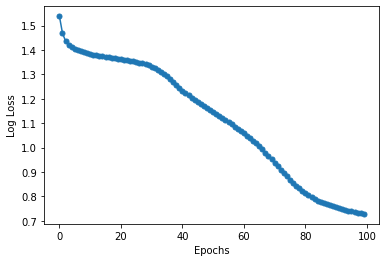

Training accuracy 0.7053
Validation accuracy 0.716
CPU times: user 370 ms, sys: 8.85 ms, total: 379 ms
Wall time: 383 ms


In [13]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="GD", display_loss=True)
print_accuracy()

### MiniBatch GD Plot



Variation of batch sizes.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


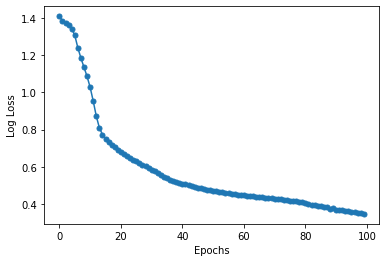

Training accuracy 0.8867
Validation accuracy 0.904
CPU times: user 492 ms, sys: 14.6 ms, total: 506 ms
Wall time: 519 ms


In [14]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=128, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


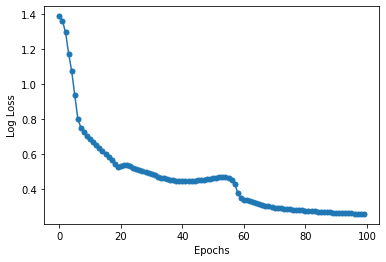

Training accuracy 0.8987
Validation accuracy 0.908
CPU times: user 483 ms, sys: 12.7 ms, total: 496 ms
Wall time: 506 ms


In [15]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=64, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


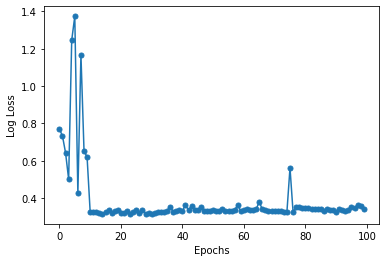

Training accuracy 0.8693
Validation accuracy 0.876
CPU times: user 1.13 s, sys: 18.6 ms, total: 1.14 s
Wall time: 1.15 s


In [16]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="MiniBatch", mini_batch_size=8, display_loss=True)
print_accuracy()

### Momentum GD Plot

Here gamma value is changed.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


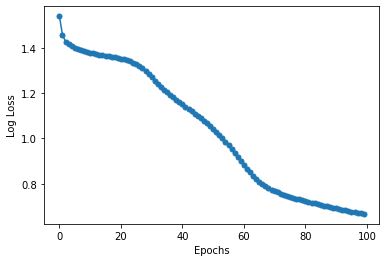

Training accuracy 0.7133
Validation accuracy 0.716
CPU times: user 386 ms, sys: 14.6 ms, total: 401 ms
Wall time: 391 ms


In [17]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.2, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


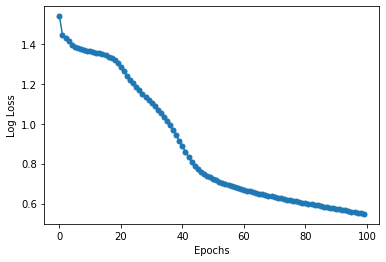

Training accuracy 0.8387
Validation accuracy 0.852
CPU times: user 362 ms, sys: 12.8 ms, total: 375 ms
Wall time: 388 ms


In [18]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


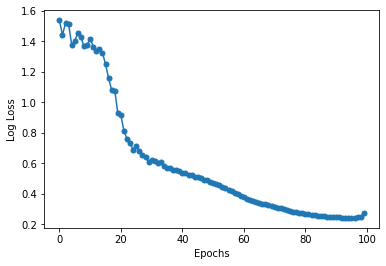

Training accuracy 0.8947
Validation accuracy 0.916
CPU times: user 367 ms, sys: 15.6 ms, total: 383 ms
Wall time: 399 ms


In [19]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


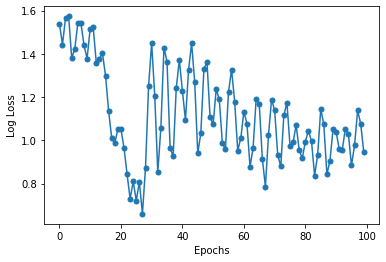

Training accuracy 0.6347
Validation accuracy 0.66
CPU times: user 336 ms, sys: 11 ms, total: 347 ms
Wall time: 355 ms


In [20]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="Momentum", gamma=0.99, display_loss=True)
print_accuracy()

### NAG GD Plot

Here gamma value is changed.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


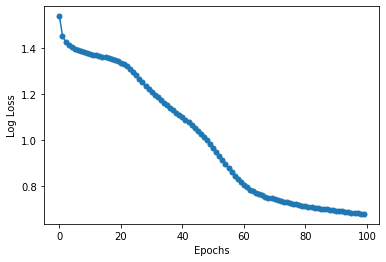

Training accuracy 0.7013
Validation accuracy 0.708
CPU times: user 380 ms, sys: 15.5 ms, total: 395 ms
Wall time: 413 ms


In [21]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.5, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


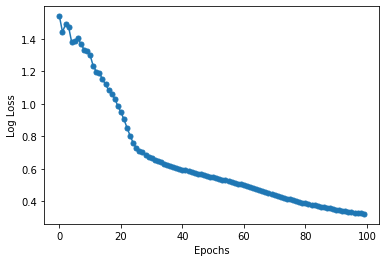

Training accuracy 0.9
Validation accuracy 0.928
CPU times: user 396 ms, sys: 13 ms, total: 410 ms
Wall time: 423 ms


In [22]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


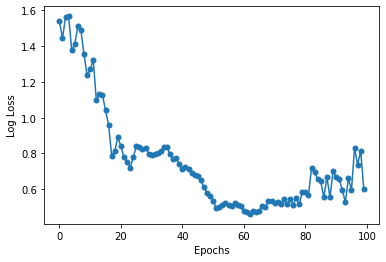

Training accuracy 0.7387
Validation accuracy 0.732
CPU times: user 378 ms, sys: 10.1 ms, total: 388 ms
Wall time: 391 ms


In [23]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="NAG", gamma=0.99, display_loss=True)
print_accuracy()

### AdaGrad GD Plots

Here eta value is changed.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


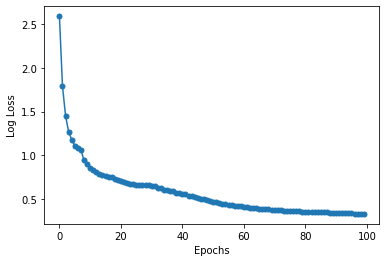

Training accuracy 0.88
Validation accuracy 0.904
CPU times: user 368 ms, sys: 11.3 ms, total: 379 ms
Wall time: 387 ms


In [24]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


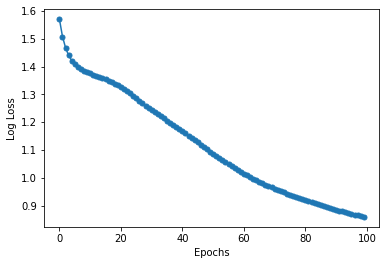

Training accuracy 0.644
Validation accuracy 0.636
CPU times: user 357 ms, sys: 13.1 ms, total: 370 ms
Wall time: 383 ms


In [25]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="AdaGrad", display_loss=True)
print_accuracy()

### RMS Prop GD Plots

Variation in eta value.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


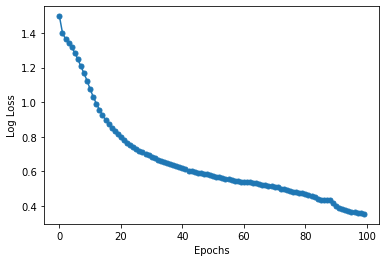

Training accuracy 0.884
Validation accuracy 0.904
CPU times: user 344 ms, sys: 4.17 ms, total: 349 ms
Wall time: 378 ms


In [26]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


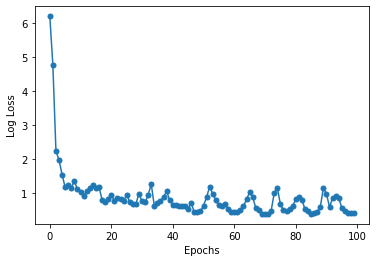

Training accuracy 0.88
Validation accuracy 0.872
CPU times: user 474 ms, sys: 9.31 ms, total: 483 ms
Wall time: 485 ms


In [27]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

### Adam GD Plots

Here eta value is changed.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


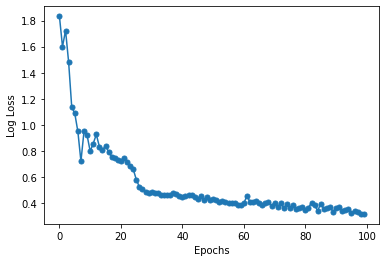

Training accuracy 0.8853
Validation accuracy 0.872
CPU times: user 373 ms, sys: 6.91 ms, total: 380 ms
Wall time: 388 ms


In [28]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.9, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


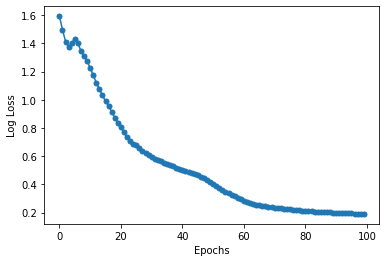

Training accuracy 0.9227
Validation accuracy 0.94
CPU times: user 382 ms, sys: 9.69 ms, total: 391 ms
Wall time: 397 ms


In [29]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=100, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

# Good Config for each Algo.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


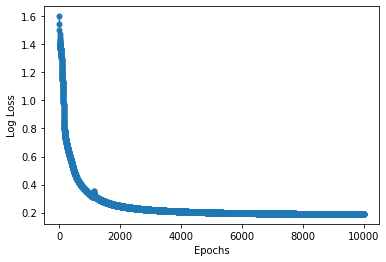

Training accuracy 0.9293
Validation accuracy 0.936
CPU times: user 15.6 s, sys: 85.4 ms, total: 15.7 s
Wall time: 15.7 s


In [30]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=10000, eta=0.5, algo="GD", display_loss=True)
print_accuracy()

For Momentum GD, there is a tradeoff between gamma and eta.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


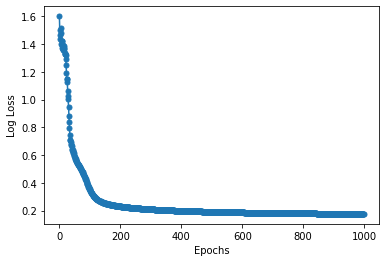

Training accuracy 0.9267
Validation accuracy 0.944
CPU times: user 1.74 s, sys: 10 ms, total: 1.75 s
Wall time: 1.77 s


In [31]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="Momentum", gamma=0.9, display_loss=True)
print_accuracy()

If Momentum is doing good, then there wont be much difference if we use NAG.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


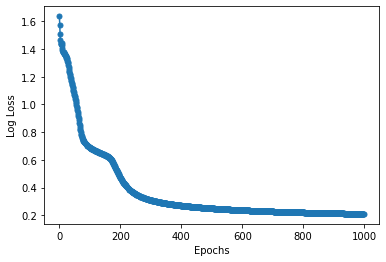

Training accuracy 0.92
Validation accuracy 0.94
CPU times: user 2.05 s, sys: 22 ms, total: 2.07 s
Wall time: 2.07 s


In [32]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=1000, eta=0.5, algo="NAG", gamma=0.9, display_loss=True)
print_accuracy()

AdaGrad does pretty good, with lesser epochs and higher eta value.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


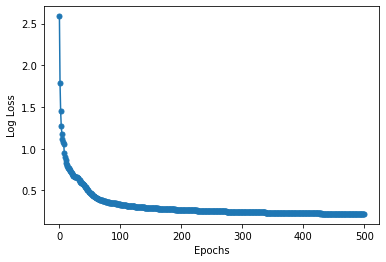

Training accuracy 0.912
Validation accuracy 0.936
CPU times: user 984 ms, sys: 14.1 ms, total: 998 ms
Wall time: 1.01 s


In [33]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=500, eta=1, algo="AdaGrad", display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


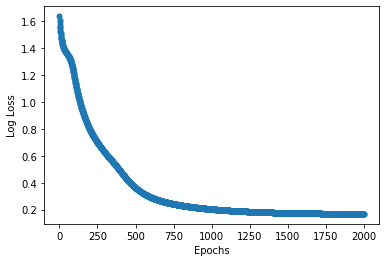

Training accuracy 0.9253
Validation accuracy 0.94
CPU times: user 3.42 s, sys: 26 ms, total: 3.45 s
Wall time: 3.51 s


In [34]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=2000, eta=.01, algo="RMSProp", beta=0.9, display_loss=True)
print_accuracy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


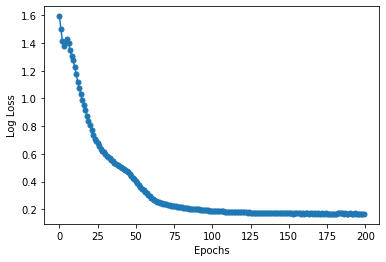

Training accuracy 0.9293
Validation accuracy 0.944
CPU times: user 529 ms, sys: 4.94 ms, total: 534 ms
Wall time: 546 ms


In [35]:
%%time
model = FFNetwork(W1, W2)
model.fit(X_train, y_OH_train, epochs=200, eta=.1, algo="Adam", beta=0.9, display_loss=True)
print_accuracy()

Exercise

0. Duplicate this exercise for our smaller network with 3 neurons (binary classification). In this case, you can practise writing the vectorised form of the gradient descent. 

1. After training for a few epochs, freeze updates to all variables, except two (say w_1 and w_2 in our diagram). Now we have a situation similar to the previous setting (where there are two variables and we can plot 2d and 3d plots). Plot the error surface and animate to visualise each algorithm. 

2. Try 1. with different parameters (say w_3, b_2) and observe how the algorithms work